# 파이썬으로 배우는 머신러닝 5강

---


머신러닝의 학습법에는 크게 지도학습, 비지도학습, 강화학습 등으로 나뉜다.

해당 챕터에선 지도 학습에 회귀에 대해 다루며, 지도학습은 훈련 데이터로부터 하나의 함수를 유추해내기 위한 머신러닝의 한 방법이다

지도학습에는 분류와 회귀가 있으며, 회귀는 입력에 대해 연속적인 값을 대응시키는 문제이며, 분류는 입력에 대해 순서가 없는 클래스(라벨)를 대응시키는 문제이다

해당 챕터에선 회귀에 대해 다룬다

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize

##1차원 입력 직선 모델

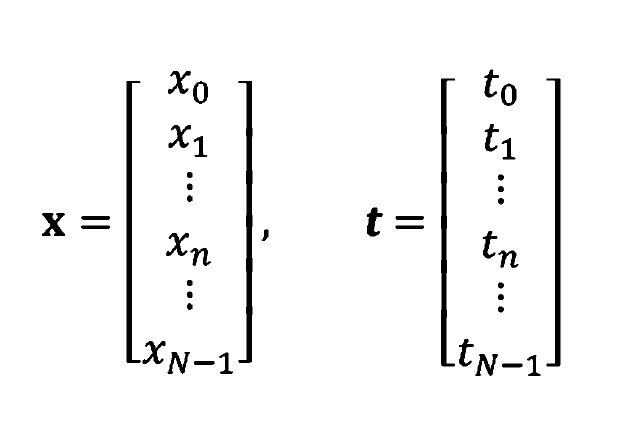

이와 같이 세로 벡터로 나타내었을때, Xn을 입력변수, Tn을 목표변수(대상)이라고 하며, n은 각 벡터의 인덱스이다.


In [ ]:
# 데이터 생성
np.random.seed(seed=1)
X_min = 4
X_max = 30
X_n = 16
X = 5 + 25 * np.random.rand(X_n)
Prm_c = [170, 108, 0.2]
T = Prm_c[0] - Prm_c[1] * np.exp(-Prm_c[2] * X) + 4 * np.random.randn(X_n)
np.savez('ch5_data.npz', X = X, X_min = X_min, X_max = X_max, X_n = X_n, T=T)

[15.42555012 23.00811234  5.00285937 12.55831432  8.66889727  7.30846487
  9.65650528 13.63901818 14.91918686 18.47041835 15.47986286 22.13048751
 10.11130624 26.95293591  5.68468983 21.76168775]
[15.43 23.01  5.   12.56  8.67  7.31  9.66 13.64 14.92 18.47 15.48 22.13
 10.11 26.95  5.68 21.76]


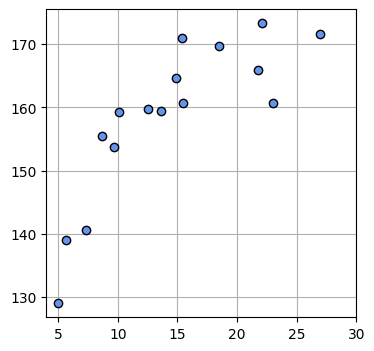

In [ ]:
print(X)

# 반올림 함수 (소수점 이하 몇자리 나타낼지 표기가능)
print(np.round(X,2))

# 그래프로 표현
plt.figure(figsize=(4,4))
plt.plot(X,T, marker='o', linestyle = 'None', markeredgecolor = 'black', color = 'cornflowerblue')
plt.xlim(X_min, X_max)
plt.grid(True)
plt.show()

1. 직선 모델

데이터의 분포상으로 선을 그었을 때, 직선으로 분포가 되지않으면 직선 모델을 만들어 이에 투영시킬 수 있다.

$$y(x)=w_0x +w_1$$



직선모델은 이와 같으며 직선이 데이터에 부합하기 위해 w0와 w1을 정하는 방법을 아래로 소개한다.

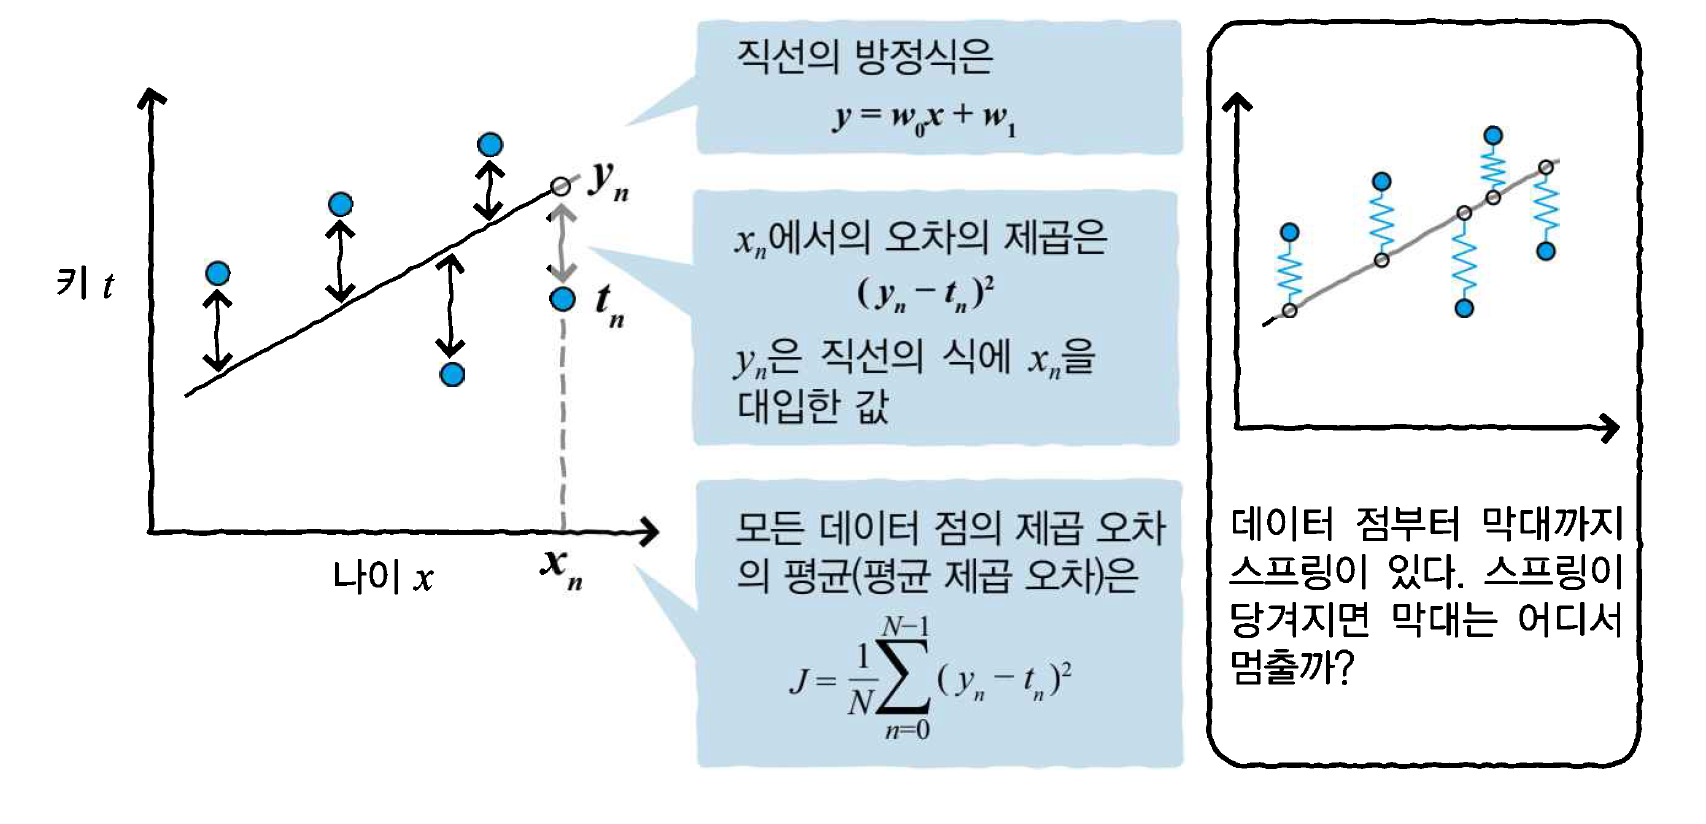

이와 같이 데이터에 부합하도록 오차 J(평균 제곱 오차)를 정의하여 직선을 구해낸다



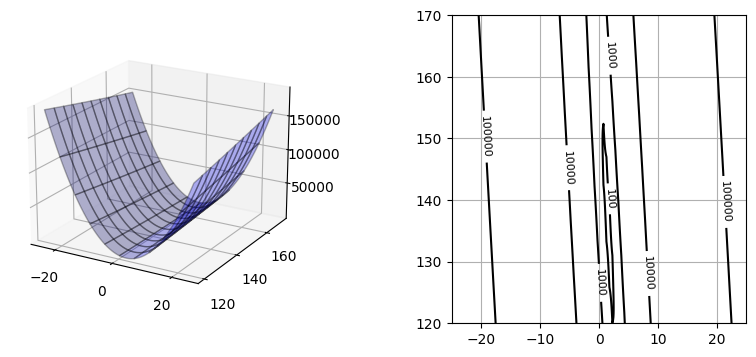

In [ ]:
# 평균 오차 함수(mse)
def mse_line(x,t,w):
  y = w[0] * x + w[1]
  mse = np.mean((y-t) **2)
  return mse

xn = 100
w0_range = [-25,25]
w1_range = [120, 170]
x0 = np.linspace(w0_range[0], w0_range[1], xn)
x1 = np.linspace(w1_range[0], w1_range[1], xn)
xx0, xx1 = np.meshgrid(x0, x1)
J = np.zeros((len(x0), len(x1)))

for i0 in range(xn):
  for i1 in range(xn):
    J[i1, i0] = mse_line(X,T, (x0[i0], x1[i1]))

# 평균 제곱오차 J
plt.figure(figsize=(9.5,4))
plt.subplots_adjust(wspace=0.5)

ax = plt.subplot(1,2,1, projection='3d')
ax.plot_surface(xx0, xx1, J, rstride=10, cstride=10, alpha=0.3, color='blue', edgecolor='black')
ax.set_xticks([-20, 0 , 20])
ax.set_yticks([120,140,160])
ax.view_init(20, -60)

# 등고선 표시
plt.subplot(1,2,2)
cont = plt.contour(xx0, xx1, J, 30, colors='black', levels = [100, 1000, 10000, 100000])
cont.clabel(fmt='%1.0f', fontsize=8)
plt.grid(True)
plt.show()

그렇다면 여기서 J가 가장 작아지는 w0 w1를 구하는게 하나의 Task가 될 수 있다.

가장 작아지는 w0 w1을 구하면 제일 적은 오차를 가지고 있는 곳을 구해 상관관계를 파악할 수 있을 것이다

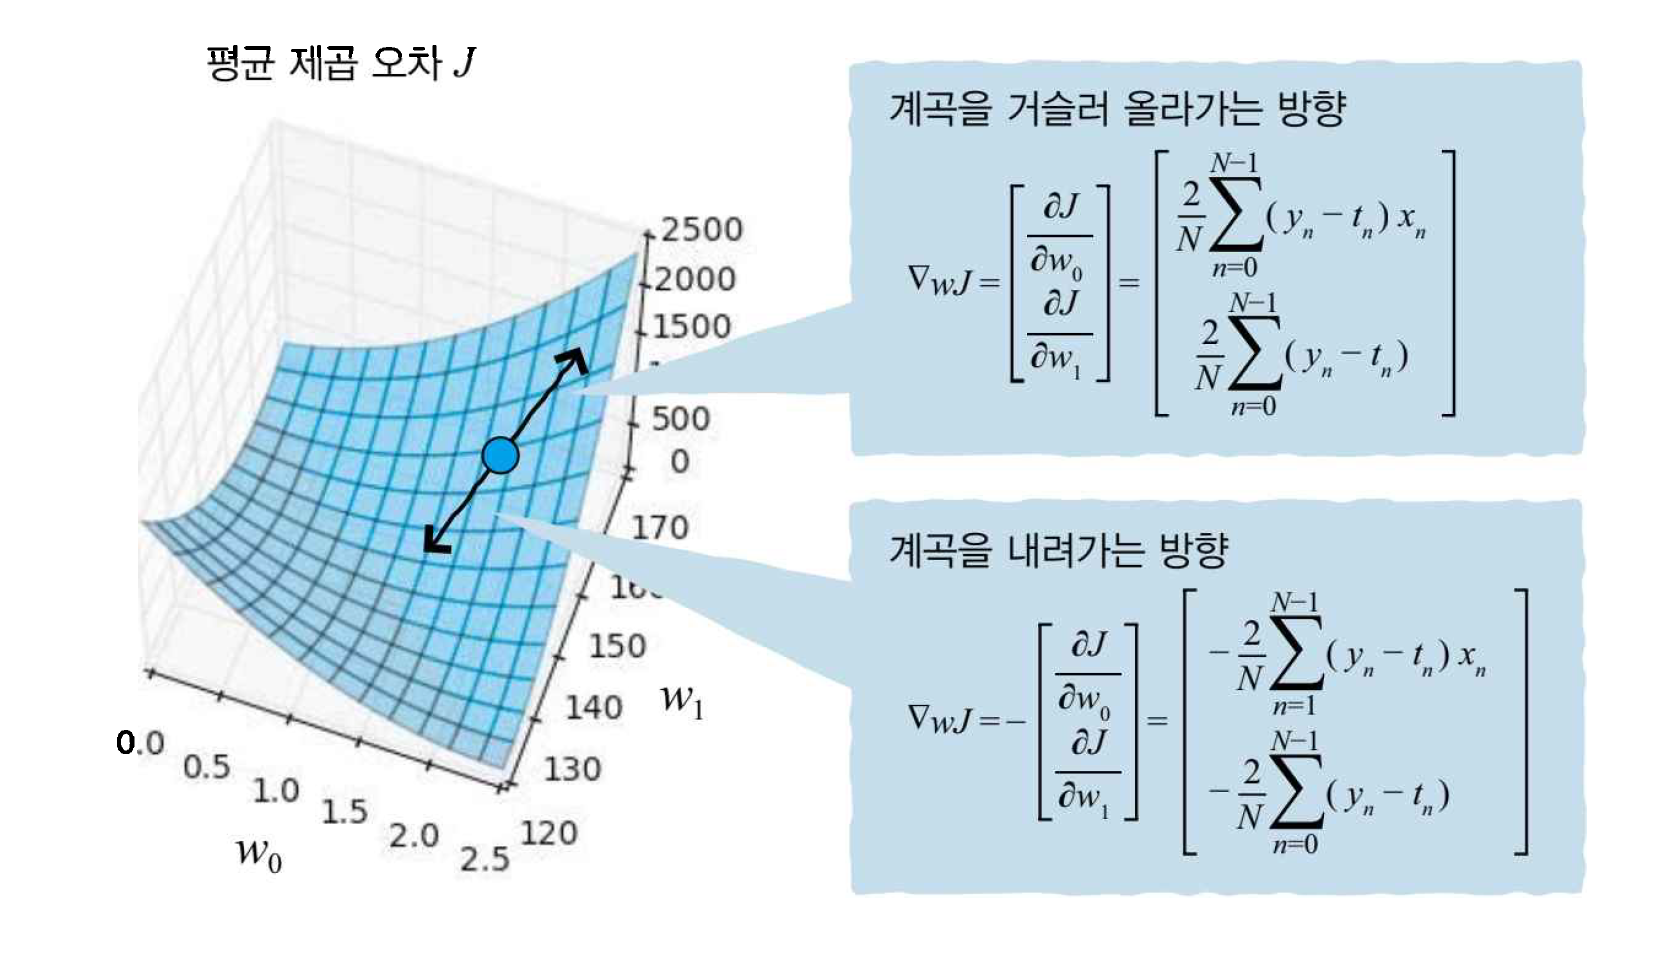

위의 그림과 같이 J를 w0, w1로 편미분하는 방향에 - 방향으로 진행을하면 최소점의 기울기를 구할 수 있다.

이 기울기를 구하게되면 대입하여 w0, w1를 구할 수 있다.

여기서의 최소가 되는 기울기를 구하는 법을 간략히 말하자면
초기에 w_init과 같은 초기점을 잡아 기울기를 갱신하며, 기울기 각 요소의 절대값이 0.1보다 작으면 계산을 종료하는 방식이다.

In [ ]:
# 경사하강법
# J가 가장 작아지는 w0과 w1을 구하는 법 (그래프의 바닥점)
# 어느 지점으로부터 w0와 w1로 편미분을하면 방향적인 벡터가 나타내게됨 이를 반대로 내리면 J의 최솟점을 구할수 있다.

# 평균 제곱 오차의 기울기
def dmse_line(x, t, w):
  y = w[0] * x + w[1]
  d_w0 = 2 * np.mean((y-t) * x)
  d_w1 = 2 * np.mean(y-t)
  return d_w0, d_w1

# 기울기 구해보기
# w0 방향과 w1 방향의 기울기를 각각 나타냄
d_w = dmse_line(X,T, [10,165])
print(np.round(d_w, 1))

[5046.3  301.8]


반복 횟수 13820
W=[1.539947, 136.176160]
dMSE=[-0.005794, 0.099991]
MSE=[49.027452


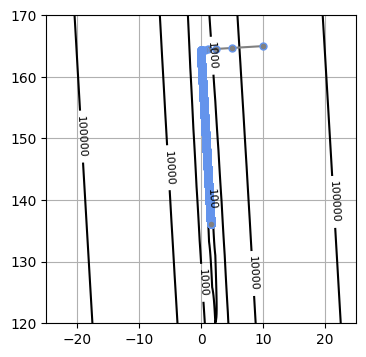

In [ ]:
# 평균 제곱 오차의 기울기를 사용한 경사하강법 구현
# w이 평평한 곳에 도달하면 w의 갱신을 종료

def fit_line_num(x,t):
  w_init = [10.0, 165.0] #초기 매개 변수
  alpha = 0.001          #학습률
  i_max = 100000         #반복의 최대수
  eps = 0.1              #반복을 종료 기울기의 절대값의 한계
  w_i = np.zeros([i_max , 2])
  w_i[0, :] = w_init
  for i in range(1, i_max):
    dmse = dmse_line(x,t, w_i[i-1])
    w_i[i, 0] = w_i[i-1, 0] - alpha * dmse[0]
    w_i[i, 1] = w_i[i-1, 1] - alpha * dmse[1]
    # 기울기가 0.1 이하면 종료
    if max(np.absolute(dmse)) < eps:
      break

  w0 = w_i[i,0]
  w1 = w_i[i,1]
  w_i = w_i[:i, :]
  return w0, w1, dmse, w_i

# 도식화 (mse_line)
plt.figure(figsize = (4,4))
xn = 100
w0_range = [-25, 25]
w1_range = [120, 170]
x0 = np.linspace(w0_range[0], w0_range[1], xn)
x1 = np.linspace(w1_range[0], w1_range[1], xn)
xx0, xx1 = np.meshgrid(x0, x1)
J = np.zeros((len(x0), len(x1)))
for i0 in range(xn):
  for i1 in range(xn):
    J[i1, i0] = mse_line(X,T, (x0[i0], x1[i1]))

cont = plt.contour(xx0, xx1, J, 30, colors = 'black', levels=(100,1000,10000,100000))
cont.clabel(fmt='%1.0f', fontsize = 8)
plt.grid(True)


# 걍사하강법
W0, W1, dMSE, W_history = fit_line_num(X,T)

print('반복 횟수 {0}'.format(W_history.shape[0]))
print('W=[{0:.6f}, {1:.6f}]'.format(W0, W1))
print('dMSE=[{0:.6f}, {1:.6f}]'.format(dMSE[0], dMSE[1]))
print('MSE=[{0:.6f}'.format(mse_line(X,T, [W0,W1])))
plt.plot(W_history[:, 0], W_history[:, 1], '.-',
         color='gray', markersize=10, markeredgecolor='cornflowerblue')
plt.show()

위의 결과를 보면 시작지점 w = [1.53, 136.2]에서 시작해서 종료 지점 w_init = [10.0, 165.0]에서 기울기가 꺾이며 0에 가까워지는 곳을 발견할 수 있다.

실제로 기울기가 0에 가까워지는 지점에서의 w0와 w1을 직선 식에 대입하면 아래와 같은 직선이 나오게 된다.

w0=1.540, w1=136.176
SD=7.002 cm


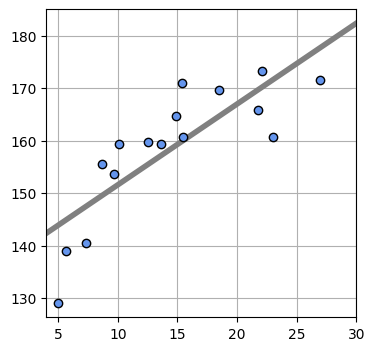

In [ ]:
# 실제로 w0와 w1이 절편과 기울기가 되는가?

def show_line(w):
  xb = np.linspace(X_min, X_max, 100)
  y = w[0] * xb + w[1]
  plt.plot(xb,y, color=(.5, .5, .5), linewidth=4)


plt.figure(figsize=(4,4))
W = np.array([W0, W1])
mse = mse_line(X,T,W)
print("w0={0:.3f}, w1={1:.3f}".format(W0, W1))
print("SD={0:.3f} cm".format(np.sqrt(mse)))
show_line(W)
plt.plot(X,T, marker='o', linestyle='None', color = 'cornflowerblue', markeredgecolor='black')
plt.xlim(X_min, X_max)
plt.grid(True)
plt.show()

위에서의 접근 방식은 경사하강법으로 반복 계산에 의해 근사값을 구하는것에 반면에 방정식을 해결하여 해를 구하는 방법도 있다.

이를 해석해라고하며, 반복 계산을 줄여 계산 비용을 줄일 수 있다.

해석해로 접근하는 방법은 아래의 두식으로부터 출발한다.

$$ \frac{\partial J}{\partial W_0}= \frac{2}{N}\displaystyle\sum_{N=0}^{N-1} (w_0x_n + w_1 -t_n)*x_n=0$$

$$ \frac{\partial J}{\partial W_0}= \frac{2}{N}\displaystyle\sum_{N=0}^{N-1} (w_0x_n + w_1 -t_n)=0$$


두식을 연립방정식 후에 아래와 같이 나타낼 수 있다.

$$w_0 = \frac{<tx>-<t><x>}{<x^2> - <x>^2}$$

$$w_1 = <t> - \frac{<tx>-<t><x>}{<x^2> - <x>^2}<x>$$


w0=1.558, w1 = 135.872
SD=7.001 c,


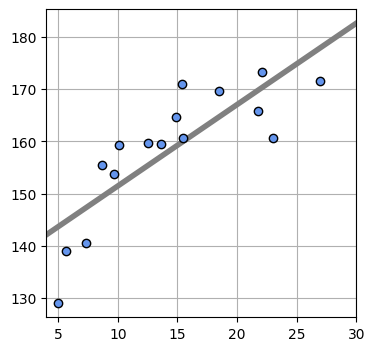

In [ ]:
# 경사하강법인 아닌 해석해로 구해보기

# 해석해 접근 방식
# 연립방정식을 통해 w0와 w1 각각으로 정의하여 접근
def fit_line(x, t):
  mx = np.mean(x)
  mt = np.mean(t)
  mtx = np.mean(t * x)
  mxx = np.mean(x * x)
  w0 = (mtx - mt * mx) / (mxx - mx **2)
  w1 = mt -w0 * mx
  return np.array([w0, w1])

W = fit_line(X,T)
print("w0={0:.3f}, w1 = {1:.3f}".format(W[0],W[1]))
mse = mse_line(X,T,W)
print("SD={0:.3f} c,".format(np.sqrt(mse)))
plt.figure(figsize=(4,4))
show_line(W)
plt.plot(X,T, marker='o', linestyle='None', color='cornflowerblue', markeredgecolor='black')
plt.xlim(X_min, X_max)
plt.grid(True)
plt.show()

## 2차원 입력면 모델



[15.43 23.01  5.   12.56  8.67  7.31  9.66 13.64 14.92 18.47 15.48 22.13
 10.11 26.95  5.68 21.76]
[70.43 58.15 37.22 56.51 57.32 40.84 57.79 56.94 63.03 65.69 62.33 64.95
 57.73 66.89 46.68 61.08]
[170.91 160.68 129.   159.7  155.46 140.56 153.65 159.43 164.7  169.65
 160.71 173.29 159.31 171.52 138.96 165.87]


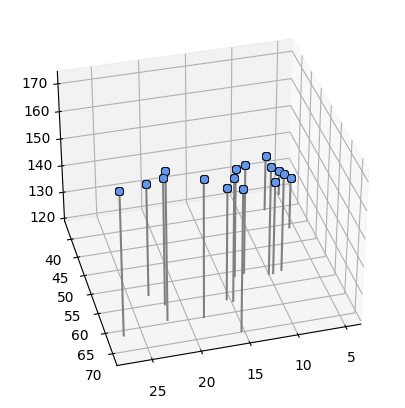

In [ ]:
# 2차원 데이터 생성

X0 = X
X0_min = 5
X0_max = 30
np.random.seed(seed=1)
X1 = 23 * (T / 100) ** 2 + 2 * np.random.randn(X_n)
X1_min = 40
X1_max = 75

print(np.round(X0, 2))
print(np.round(X1, 2))
print(np.round(T, 2))

# 16명의 X0, X1, T를 바탕으로 3차원 플롯의 그래프를 표시함

def show_data2(ax, x0, x1, t):
  for i in range(len(x0)):
    ax.plot([x0[i], x0[i]], [x1[i], x1[i]],
            [120, t[i]], color='gray')
    ax.plot(x0, x1, t, 'o',
            color = 'cornflowerblue', markeredgecolor='black',
            markersize = 6, markeredgewidth=0.5)
    ax.view_init(elev=35, azim=75)

plt.figure(figsize=(6,5))
ax = plt.subplot(1,1,1,projection='3d')
show_data2(ax,X0,X1,T)
plt.show()

SD=12.876 cm


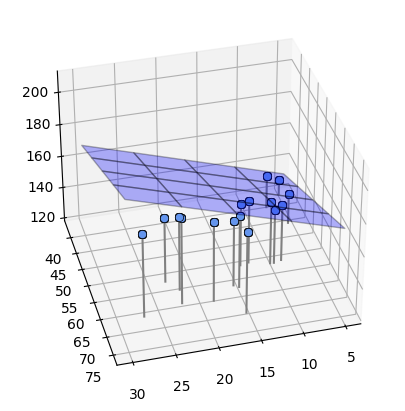

In [ ]:
# 데이터 표시 방법 (데이터 번호 = n, 벡터의 요소(0=나이,1 = 몸무게 등), 요소 번호 = m)

# 면의 표시
def show_plane(ax, w):
  px0 = np.linspace(X0_min, X0_max, 5)
  px1 = np.linspace(X1_min, X1_max, 5)
  px0, px1 = np.meshgrid(px0, px1)
  y = w[0]* px0 + w[1] + px1 + w[2]
  ax.plot_surface(px0, px1, y, rstride=1, cstride=1, alpha=0.3, color= 'blue', edgecolor='black')

# 면의 MSE

def mse_plane(x0, x1, t, w):
  y = w[0] * x0 + w[1] * x1 + w[2]
  mse = np.mean((y-t)**2)
  return mse

plt.figure(figsize=(6,5))
ax = plt.subplot(1,1,1, projection='3d')
W = [1.5, 1, 90]
show_plane(ax, W)
show_data2(ax, X0, X1, T)
mse = mse_plane(X0, X1, T, W)
print("SD={0:.3f} cm".format(np.sqrt(mse)))
plt.show()

2차원 면 모델의 경우에도 1차원의 선 모델과 마찬가지로 평균 제곱 오차를 해석해로 정의 가능

$$J= \frac{1}{N}\displaystyle\sum_{N=0}^{N-1} (y(x_n)-t_n)^2=\frac{1}{N}\displaystyle\sum_{N=0}^{N-1} (w_0x_{n,0}+w_1x_{n,1}+w_2-t_n)^2$$

J를 최소화하는 최적의 w를 구하는 것이며 각각 편미분을 해서 w0, w1, w2를 구한다. 결과적 w0, w1, w2는 아래와 같다

$$W_0 = \frac{cov(t,x_a)cov(x_0,x_a)-var(x_1)cov(t,x_0)}{cov(x_0,x_1)^2 - var(x_0)var(x_1)}$$





$$W_1 = \frac{cov(t,x_a)cov(x_0,x_a)-var(x_1)cov(t,x_1)}{cov(x_0,x_1)^2 - var(x_0)var(x_1)}$$


$$W_2=-w_0<x_0>-w_1<x_1>+<t>$$

w0=0.5, w1=1.1, w2=89.0
SD=2.546 cm


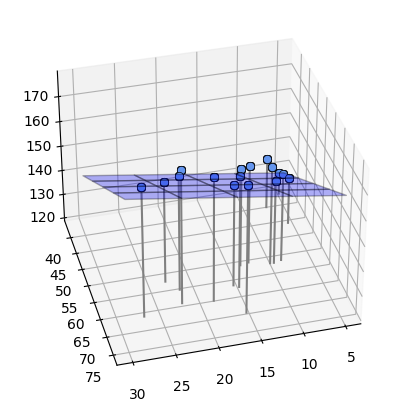

In [ ]:
# 매개 변수의 해석해
# 2차원 면 모델의 경우에도 1차원의 선 모델과 마찬가지로 평균 제곱 오차를 해석해로 정의 가능


def fit_plane(x0, x1, t):
  c_tx0 = np.mean(t * x0) - np.mean(t) * np.mean(x0)
  c_tx1 = np.mean(t * x1) - np.mean(t) * np.mean(x1)
  c_x0x1 = np.mean(x0 * x1) - np.mean(x0) * np.mean(x1)
  v_x0 = np.var(x0)
  v_x1 = np.var(x1)

  w0 = (c_tx1 * c_x0x1 - v_x1 * c_tx0) / (c_x0x1 ** 2 - v_x0 * v_x1)
  w1 = (c_tx0 * c_x0x1 - v_x0 * c_tx1) / (c_x0x1 ** 2 - v_x0 * v_x1)
  w2 = -w0 * np.mean(x0) - w1 * np.mean(x1) + np.mean(t)
  return np.array([w0, w1, w2])


plt.figure(figsize=(6,5))
ax = plt.subplot(1,1,1, projection='3d')
W = fit_plane(X0, X1, T)
print("w0={0:.1f}, w1={1:.1f}, w2={2:.1f}". format(W[0], W[1], W[2]))
show_plane(ax, W)
show_data2(ax, X0, X1, T)
mse = mse_plane(X0, X1, T, W)
print("SD={0:.3f} cm".format(np.sqrt(mse)))
plt.show()

## D차원 선형 회귀 모델

D차원일 경우 y(x) = W0 * X0 + W1 * X1 + ... + Wd-1 * Xd-1 + Wd = W^t * X
해석해로도 표현가능



### 매개 변수의 해석해
지금까지와 마찬가지로 평균 제곱 오차 J를 아래와 같이 나타낸다.

$$J(w) = {1 \over N} \sum_{n=0}^{N-1} (y(x_{n}) - t_{n})^2 = {1 \over N} \sum_{n=0}^{N-1} (w^Tx- t_{n})^2 $$  

Wi로 미분

$$ {\partial f \over \partial w_{j}}= {1\over N} \sum_{n=0}^{N-1} {\partial f \over \partial w_{j}} (w^Tx_{n} - t_{n})^2 = {2\over N} \sum_{n=0}^{N-1} {\partial f \over \partial w_{j}} (w^Tx_{n} - t_{n})x_{n, i}  $$

이후 정리하면 아래와 같은 식이 나타난다.

$$ \sum_{n=0}^{N-1} (w^Tx_{n} - t_{n})x_{n, i} = 0 $$  

$$ x_{n, i} = x_{n}^T$$

$$ \sum_{n=0}^{N-1} (w^Tx_{n} - t_{n})x_{n}^T = 0 $$  

이 식을 행렬의 식으로 변환하기 위해 아래의 식 사용

$$ \sum_{n=0}^{N-1} X_{n}X_{n}^T = X^TX $$
$$ \sum_{n=0}^{N-1} t_{n}X_{n}^T = t^TX $$  

결과적으로 아래로 변환가능
$$  \mathbf w^T \mathbf x^T \mathbf x - \mathbf t^T \mathbf x =  \begin{bmatrix} 0 & 0& \cdots & 0 \end{bmatrix} $$

위의 식을 전치 후에 좌변 두항에 외부의 T를 작용시키고 관계식을 적용하여 정리하면 D차원 선형회귀 모델의 해를 구할 수 있다.

$$w=(X^TX)^{-1}X^Tt$$





특징

1. x가 어떤 차원이더라도 모두 이 형태에서 최적의 W를 얻을 수 있다.

2. 위 식의 우변에는 무어-펜로즈 의사 역행렬이라는 행렬이다.

원점을 지나지 않는 면에 대한 확장
y(x) = W0 * X0 + W1 * X1 -> W2를 더해서 면을 위로 이동한 후 원점을 지나지 않는 면을 표시할 수 있음

W2 * X2를 더해주어 X2에 1을 추가한 후 3차원 벡터로 표현가능함

-> D+1번째 차원에 항상 1을 얻는 요소를 추가하면 자유롭게 움직이는 모델을 표현할 수 있다

## 선형 기저 함수 모델

직선을 사용하면 오차가 클수 있음, 그렇기에 오차가 더 작아질 수 있는 곡선 모델을 생각해본다.

기저 함수는 바탕이 되는 함수라는 뜻이다. 여기서는 가우스 함수를 기저 함수로 선택한 선형 기저 함수 모델을 생각한다.

(보편성 높음 -> 대부분의 데이터는 가우스함수분포에 적합할 가능성이 크다.)

$$ \phi _j(x) =exp\left(\frac{(x-	\mu_j)^2}{2s^2}\right)$$

기저함수는 위와 같이 '파이($\phi$)'로 나타내며 가우스 함수의 중심 위치($\mu_j$)와 함수의 확장 정도(s)는 모델의 설계자가 결정하는 매개 변수로 분리된다.



In [ ]:
# 직선이 아닌 선형적으로 접근

# 데이터 로드
outfile = np.load('ch5_data.npz')
X = outfile['X']
X_min = outfile['X_min']
X_max = outfile['X_max']
X_n = outfile['X_n']
T = outfile['T']

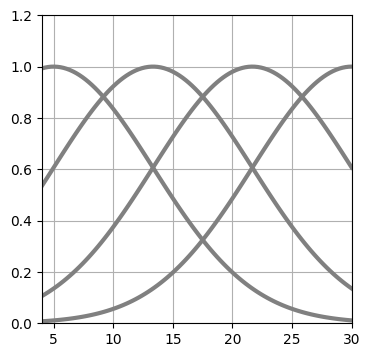

In [ ]:
# 가우스 함수
def gauss(x, mu, s):
  return np.exp(-(x-mu) **2 / (2 * s**2))

# 도식화
M = 4
plt.figure(figsize=(4,4))
mu = np.linspace(5, 30, M)
s = mu[1] - mu[0]
xb = np.linspace(X_min, X_max, 100)
for j in range(M):
  y = gauss(xb, mu[j], s)
  plt.plot(xb, y, color='gray', linewidth=3)
plt.grid(True)
plt.xlim(X_min, X_max)
plt.ylim(0, 1.2)
plt.show()


M = 4일때의 가우스 기저함수

선형 기저 함수 모델의 식

$$y(x,w)=w_0\phi_0(x)+w_1\phi_1(x)+w_2\phi_2(x)+w_3\phi_3(x)+w_4$$

매개 변수 w를 '가중치 매개 변수'라고 하며, 이 같은 계산을 '가중치를 붙여 더하면'이라고 표현한다.

마지막 W4 는 곡선 상하의 평행이동을 조절하는 중요하지만 다른 매개 변수와 달리 파이가 곱해지지않는다.

그렇기에 항상 1을 출력하는 더미 기초함수를 추가하여 아래와 같이 나타낸다.


$$J(w) = {1 \over N} \sum_{j=0}^{N-1} (w^Tϕ(x_n) - t_{n})^2 $$

기존 식에서 파이로만 바꼈을뿐이다. 이 사실로부터 선형 기저 함수 모델은 다음과 같이 해석된다.

- '전처리'로, 1차원 데이터 $x_n$을 M차원의 데이터 벡터 $x_n = \phi(x_n)$ 으로 변환
- M차원 입력 $x_n$에 대해 선형 회귀 모델을 적용
- 따라서 J를 최소화하는 매개 변수 W는 위의 해석해에서 X를 $\phi$로 대체한 아래의 식으로 나타낼 수 있다
$$w=(ϕ^Tϕ)^{-1}ϕ^Tt$$
- 여기서 $\phi$는 전처리를 한 후 입력을 나타내며, 이를 계획 행렬이라고 한다.

W[29.4 75.7  2.9 98.3 54.9]
SD = 3.98 cm


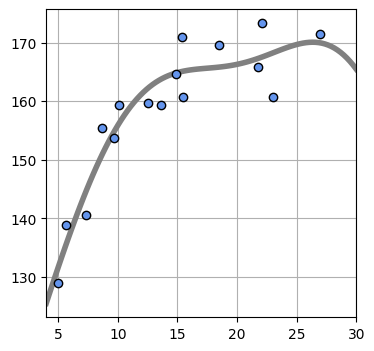

In [ ]:
# 선형 기저 함수 모델
# '전처리'로, 1차원 데이터 Xn을 M차원의 데이터 벡터로 변환
# M차원 입력 Xn에 대해 선형 회귀 모델 적용

# 선형 기저 함수 모델


def gauss_func(w, x):  # 선형 기저 함수 모델
    m = len(w) - 1
    mu = np.linspace(5, 30, m)
    s = mu[1] - mu[0]
    y = np.zeros_like(x) # x와 같은 크기로 요소가 0의 행렬 y를 작성
    for j in range(m):
        y = y + w[j] * gauss(x, mu[j], s)
    y = y + w[m]
    return y

# 선형 기저 함수 모델 MSE
def mse_gauss_func(x, t, w):
  y = gauss_func(w, x)
  mse = np.mean((y-t) ** 2)
  return mse

# 선형 기저 함수 모델의 매개 변수의 해석해 풀이

def fit_gauss_func(x, t, m):
  mu = np.linspace(5, 30 ,m)
  s = mu[1] - mu[0]
  n = x.shape[0]
  psi = np.ones((n, m+1))
  for j in range(m):
    psi[:, j] = gauss(x,mu[j], s)
  psi_T = np.transpose(psi)

  b = np.linalg.inv(psi_T.dot(psi))
  c = b.dot(psi_T)
  w = c.dot(t)
  return w

# 가우스 기저 함수 표시
def show_gauss_func(w):
  xb = np.linspace(X_min, X_max, 100)
  y = gauss_func(w, xb)
  plt.plot(xb, y, c=[.5, .5, .5], lw = 4)

# 도식화

plt.figure(figsize=(4,4))
M = 4
W = fit_gauss_func(X,T,M)
show_gauss_func(W)
plt.plot(X, T, marker='o', linestyle='None', color='cornflowerblue', markeredgecolor='black')
plt.grid(True)
plt.xlim(X_min, X_max)
mse = mse_gauss_func(X,T,W)
print('W' + str(np.round(W,1)))
print("SD = {0:.2f} cm".format(np.sqrt(mse)))
plt.show()

## 오버피팅의 문제

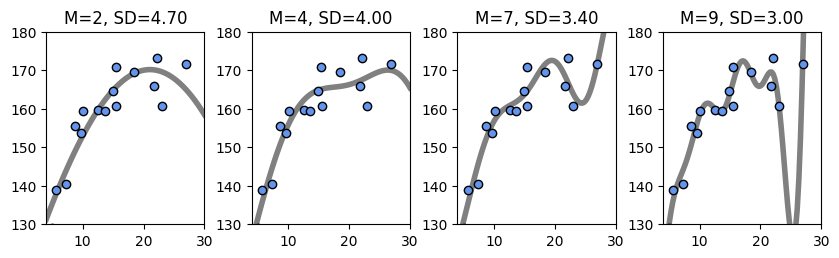

In [ ]:
# 기저함수(M)를 정하는법

plt.figure(figsize=(10, 2.5))
plt.subplots_adjust(wspace=0.3)
M = [2, 4, 7, 9]
for i in range(len(M)):
  plt.subplot(1, len(M), i+1)
  W = fit_gauss_func(X, T, M[i])
  show_gauss_func(W)
  plt.plot(X, T, marker='o', linestyle='None', color = 'cornflowerblue', markeredgecolor='black')
  plt.xlim(X_min, X_max)
  plt.ylim(130,180)
  mse = mse_gauss_func(X,T,W)
  plt.title("M={0:d}, SD={1:.1f}0".format(M[i], np.sqrt(mse)))

plt.show()


M이 늘어나면 오차의 표준 편차 SD는 점점 줄어들지만 가우스 기저함수는 신뢰도를 잃는다.

그렇기에 새로운 입력에 대한 예측이 잘 되지 않으며 이 현상을 과적합이라고 한다.

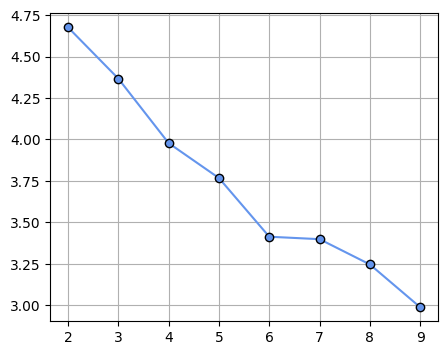

In [ ]:
# 정량적으로 보기위해 M=2 ~ 9까지의 SD를 계산후 도식화

plt.figure(figsize=(5,4))
M = range(2, 10)
mse2 = np.zeros(len(M))
for i in range(len(M)):
  W = fit_gauss_func(X,T, M[i])
  mse2[i] = np.sqrt(mse_gauss_func(X,T,W))

plt.plot(M, mse2, marker='o', color = 'cornflowerblue', markeredgecolor='black')
plt.grid(True)
plt.show()

M이 증가함에 따라 오차의 표준 편차 SD는 점점 줄어드는 모습이며 이 SD는 최적의 M의 기준은 안된다.

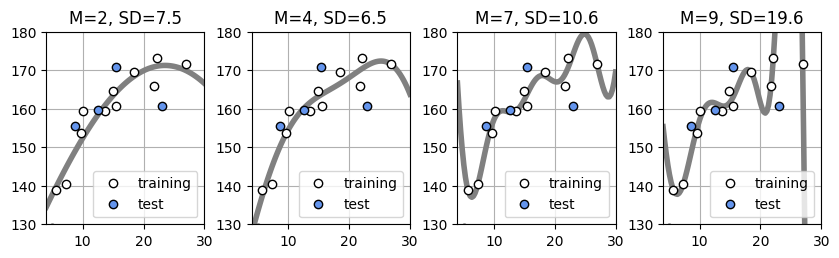

In [ ]:
# 훈련 데이터와 테스트 데이터

X_test = X[:int(X_n / 4 + 1)]
T_test = T[:int(X_n / 4 + 1)]
X_train = X[int(X_n / 4 + 1):]
T_train = T[int(X_n / 4 + 1):]

# 도식화
plt.figure(figsize=(10, 2.5))

plt.subplots_adjust(wspace=0.3)
M = [2, 4, 7, 9]
for i in range(len(M)):
  plt.subplot(1, len(M), i + 1)
  W = fit_gauss_func(X_train, T_train, M[i])
  show_gauss_func(W)
  plt.plot(X_train, T_train, marker='o', linestyle='None', color= 'white', markeredgecolor='black', label='training')
  plt.plot(X_test, T_test, marker='o', linestyle='None', color='cornflowerblue', markeredgecolor='black', label='test')
  plt.legend(loc='lower right', fontsize=10, numpoints=1)
  plt.xlim(X_min, X_max)
  plt.ylim(130, 180)
  plt.grid(True)
  mse = mse_gauss_func(X_test, T_test, W)
  plt.title("M={0:d}, SD={1:.1f}".format(M[i], np.sqrt(mse)))

plt.show()

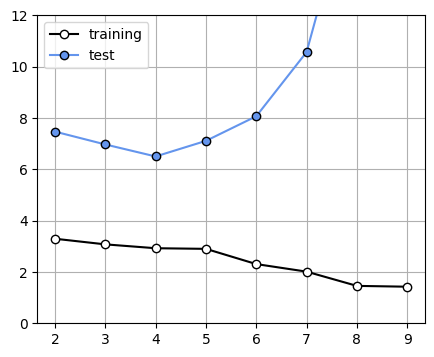

In [ ]:
# 경향을 정량적 표기 -> 훈련 데이터와 테스트 데이터의 오차(SD)

plt.figure(figsize = (5,4))
M = range(2,10)
mse_train = np.zeros(len(M))
mse_test = np.zeros(len(M))
for i in range(len(M)):
  W = fit_gauss_func(X_train, T_train, M[i])
  mse_train[i] = np.sqrt(mse_gauss_func(X_train, T_train, W))
  mse_test[i] = np.sqrt(mse_gauss_func(X_test, T_test, W))

plt.plot(M,mse_train, marker = 'o', linestyle='-', markerfacecolor='white', markeredgecolor='black', color='black', label='training')
plt.plot(M,mse_test, marker = 'o', linestyle='-', markeredgecolor='black', color='cornflowerblue', label='test')
plt.legend(loc='upper left', fontsize=10)
plt.ylim(0, 12)
plt.grid(True)
plt.show()

위의 그래프의 경향을 보면 M=4까지 수렴하고 M=5부터 발산함 -> 오버피팅

(호드아웃에 의한 선형 기저 함수모델의 검증에서 M=4의 경우가 가장 데이터에 적합하다.)

데이터의 분류법에 따라 홀드 아웃의 결과가 아래의 그림과 같이 달라짐

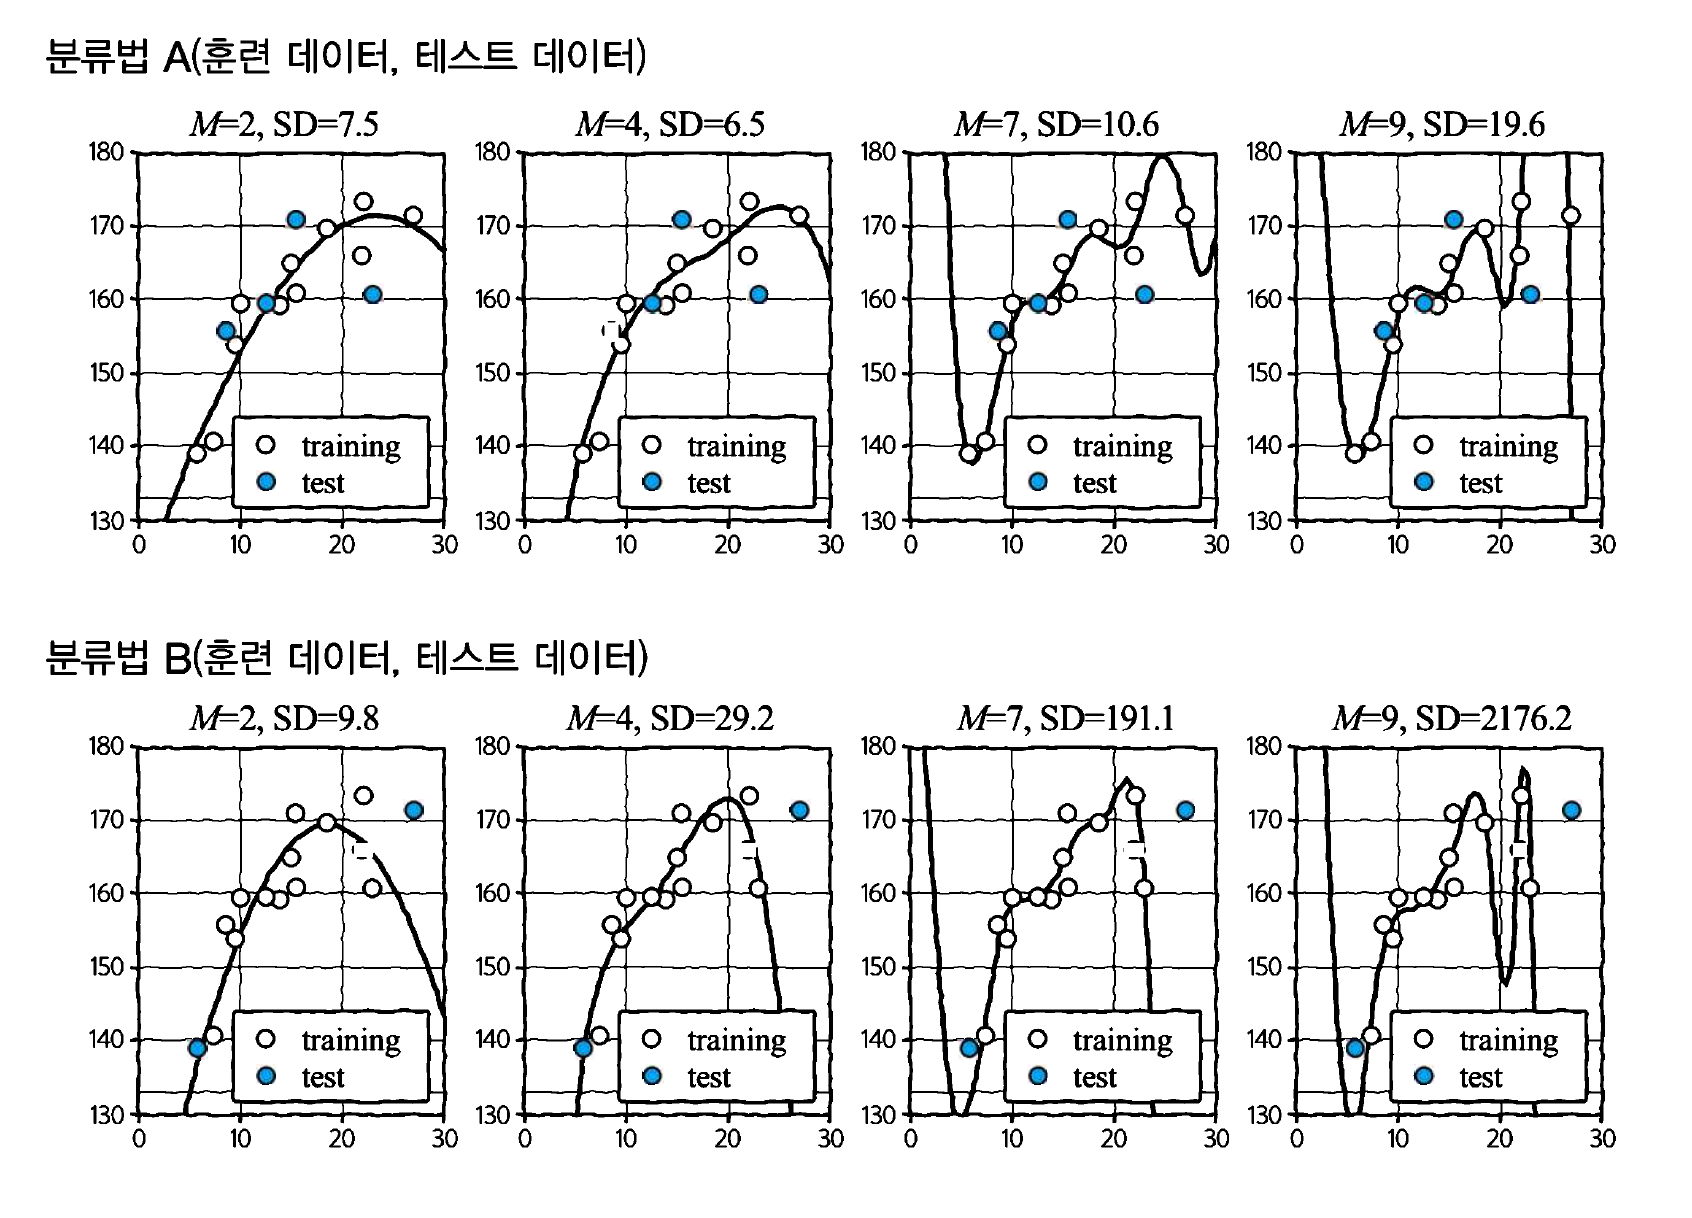

위의 차이를 최소한으로 줄이기 위해 교차 검증방법을 사용하며,

데이터를 분할하는 종류의 갯수로 K겹 교차 검증으로 불리기도 하는 방법을 사용한다.

K겹 교차 검증 방법

1. 데이터 X와 t를 K개로 분할한다.
2. 이 중 하나를 테스트 데이터 셋으로 잡고 나머지를 훈련 데이터로 잡는다.
3. 훈련 데이터를 사용해 모델 매개 변수를 최적화하고, 테스트 데이터의 평균 제곱 오차(MSE)를 계산한다.
4. 테스트 데이터를 바꾸어 이 절차를 K회 반복한다.
5. 마지막으로 K개의 평균 제곱 오차의 평균을 취하여 평가치로 사용한다.

최대 분할수 K=N

이때, 테스트 데이터의 크기는 1이고 이 경우 LOOCV라고 불림.

In [ ]:
# K겹 교차 검증
# K개 만큼 분할을 하여 검증하는 법

def kfold_gauss_func(x, t, m, k):
  n = x.shape[0]
  mse_train = np.zeros(k)
  mse_test = np.zeros(k)

  for i in range(0, k):
    x_train = x[np.fmod(range(n), k) != i ]
    t_train = t[np.fmod(range(n), k) != i ]
    x_test = x[np.fmod(range(n), k) == i]
    t_test = t[np.fmod(range(n), k) == i]
    wm = fit_gauss_func(x_train, t_train, m)
    mse_train[i] = mse_gauss_func(x_train, t_train, wm)
    mse_test[i] = mse_gauss_func(x_test, t_test, wm)
  return mse_train, mse_test

In [ ]:
# 0 ~ k-1까지를 반복하는 n개의 리스트
np.fmod(range(10),5)

#기저 M=4, K=4
M = 4
K = 4

# Train, Test에서의 평균 제곱 오차
kfold_gauss_func(X,T,M,K)


(array([12.87927851,  9.81768697, 17.2615696 , 12.92270498]),
 array([ 39.65348229, 734.70782018,  18.30921743,  47.52459642]))

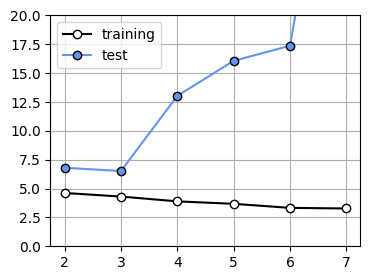

In [ ]:
M = range(2,8)
K = 16
Cv_Gauss_train = np.zeros((K, len(M)))
Cv_Gauss_test = np.zeros((K, len(M)))

for i in range(0, len(M)):
  Cv_Gauss_train[:, i], Cv_Gauss_test[:, i] = kfold_gauss_func(X, T, M[i], K)

mean_Gauss_train = np.sqrt(np.mean(Cv_Gauss_train, axis=0))
mean_Gauss_test = np.sqrt(np.mean(Cv_Gauss_test, axis=0))

plt.figure(figsize=(4,3))
plt.plot(M, mean_Gauss_train, marker='o', linestyle='-', color= 'k', markerfacecolor='w', label='training')
plt.plot(M, mean_Gauss_test, marker='o', linestyle='-', color= 'cornflowerblue', markeredgecolor='black', label='test')
plt.legend(loc='upper left', fontsize=10)
plt.ylim(0,20)
plt.grid(True)
plt.show()

LOOCV에서는 M=3이 가장 적합하며,

홀드 아웃 검증보다 신뢰성이 있는 결과라고 볼 수 있다.
(평균치를 사용함으로)


SD=4.37 cm


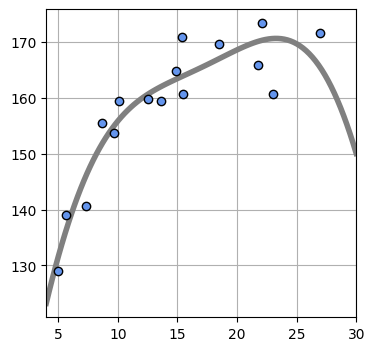

In [ ]:
# M = 3이 최적임을 확인 후 그 모델의 매개 변수 W를 모든 데이터를 사용해 계산
# 이 매개 변수 W를 사용한 곡선으로 미지의 입력 데이터 x에 대한 예측 y를 출력

M = 3
plt.figure(figsize=(4,4))
W = fit_gauss_func(X, T, M)
show_gauss_func(W)
plt.plot(X,T, marker='o', linestyle='None', color='cornflowerblue', markeredgecolor='black')
plt.xlim([X_min, X_max])
plt.grid(True)
# 오차의 표준편차
mse = mse_gauss_func(X, T, W)
print("SD={0:.2f} cm".format(np.sqrt(mse)))
plt.show()

위와 같이 테스트 데이터 셋이 적은 경우에는 교차 검증이 유용하다.

하지만 데이터 수가 많아지면 교차 검증은 계산비용이 많이 든다.

그렇기에 데이터수가 많으면 sample의 수가 많아지는 것으로 홀드 아웃 검증을 써도 신뢰성을 어느정도 확보할 수 있다.


## 새로운 모델의 생성

일정 부분에 데이터가 충분하지 않을 때 비상식적인 결과를 나타낼 수 있음.

이를 해결하기위해 일정한 값으로 수렴하는 함수를 만들어 넣을 수 있음.



$$y(x)=w_0 -w_1exp(-w_2x)$$

x가 증가하면 exp(-w2x)는 0에 접근하며 그 결과 1항의 w0만 값을 갖게 된다.

즉 x가 증가하면 y는 w0에 가까워지며 w0는 수렴하는 값을 경정하는 매개변수가 된다.

여기서 w0은 수렴하는 값을 결정하는 매개변수, w1은 그래프의 시작점을 결정하는 매개변수, w2는 그래프의 기울기를 결정하는 매개변수 이다.

w0=169.0, w1=113.7, w2=0.2
SD=3.86 cm


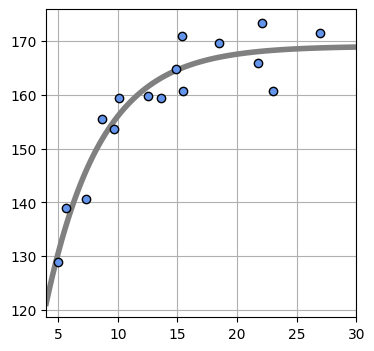

In [ ]:
# 모델
def model_A(x,w):
  y = w[0] -w[1] * np.exp(-w[2] * x)
  return y

# 도식화
def show_model_A(w):
  xb = np.linspace(X_min, X_max, 100)
  y = model_A(xb,w)
  plt.plot(xb, y, c=[.5, .5, .5], lw=4)

# 모델의 mse
def mse_model_A(w,x,t):
  y = model_A(x, w)
  mse = np.mean((y-t) ** 2)
  return mse

# 모델의 매개 변수 최적화
# 반복연산을 위한 매개변수의 초기값, 입력데이터, 목표데이터가 들어감
def fit_model_A(w_init, x, t):
  res1 = minimize(mse_model_A, w_init, args=(x,t), method="powell")
  return res1.x

# 메인

plt.figure(figsize=(4,4))
W_init = [100, 0 ,0]
W = fit_model_A(W_init, X, T)
print("w0={0:.1f}, w1={1:.1f}, w2={2:.1f}".format(W[0], W[1], W[2]))
show_model_A(W)
plt.plot(X, T, marker='o', linestyle='None', color='cornflowerblue', markeredgecolor='black')
plt.xlim(X_min, X_max)
plt.grid(True)
mse = mse_model_A(W, X , T)
print("SD={0:.2f} cm".format(np.sqrt(mse)))
plt.show()

오차의 SD는 직선 모델일 때보다 확연히 줄어들었으며,

M = 3의 선형 기저 함수 모델보다도 낮은 값이 나왔다.

(3.86 < 4.32 < 7.00)

## 모델의 선택

어떤 모델이 좋을지의 비교하는법으로 미지의 데이터에 대한 예측 정확도로 평가하는 것이 제일 유효함

-> 홀드 아웃 검증과 교차 검증 모델로 모델의 좋고 나쁨을 평가할 수 있다.

Gauss(M=3) SD=6.51 cm
model A SD=4.72 cm


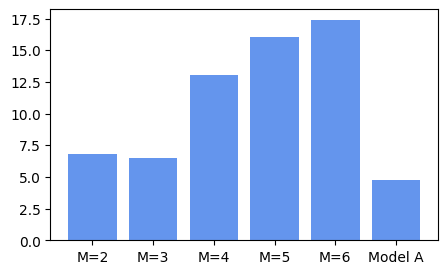

In [ ]:
# 교차 검증 model_A

def kfold_model_A(x, t, k):
  n = len(x)
  mse_train = np.zeros(k)
  mse_test = np.zeros(k)
  for i in range(0, k):
    x_train = x[np.fmod(range(n), k) != i]
    t_train = t[np.fmod(range(n), k) != i]
    x_test = x[np.fmod(range(n), k) == i]
    t_test = t[np.fmod(range(n), k) == i]
    wm = fit_model_A(np.array([169, 113, 0.2]), x_train, t_train)
    mse_train[i] = mse_model_A(wm, x_train, t_train)
    mse_test[i] = mse_model_A(wm, x_test, t_test)

  return mse_train, mse_test

# 메인

K = 16
Cv_A_train, Cv_A_test = kfold_model_A(X, T, K)
mean_A_test = np.sqrt(np.mean(Cv_A_test))
print("Gauss(M=3) SD={0:.2f} cm".format(mean_Gauss_test[1]))
print("model A SD={0:.2f} cm".format(mean_A_test))
SD = np.append(mean_Gauss_test[0:5], mean_A_test)
M = range(6)

label = ["M=2", "M=3", "M=4", "M=5", "M=6","Model A"]

plt.figure(figsize=(5, 3))
plt.bar(M, SD, tick_label=label, align = "center", facecolor="cornflowerblue")
plt.show()